In [47]:
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
import matplotlib.pyplot as plt
import imageio
from imgaug import augmenters as iaa
import imgaug as ia
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import numpy as np
import utils.augment
import kornia
import torch.nn as nn
from torchvision import transforms

In [48]:

# Define an augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))), # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # apply one of the augmentations: Dropout or CoarseDropout
    iaa.OneOf([
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ])
],
random_order=True # apply the augmentations in random order
)

In [104]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, augmentations = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')
        self.augmentations = nn.Sequential(
                kornia.augmentation.RandomVerticalFlip(0.5)
            )

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
        
        img_nd = np.array(pil_img)
        print(img_nd.shape)
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
        
        imgplot = plt.imshow(pil_img)
        plt.show()
        #rounding the image
        
        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255
#         img_trans = np.around(img_trans)
#         imgplot = plt.imshow(img_trans)
#         plt.show()
        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        print(idx)
        mask_file = glob(self.masks_dir + idx + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        mask = mask.convert('L')
        img = Image.open(img_file[0])
        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        
        image_augmented = self.augmentations(transforms.ToTensor()(img).unsqueeze(0))
        mask_augmented = self.augmentations(torch.from_numpy(np.array(mask)).type(torch.FloatTensor))
        image_augmented = image_augmented.squeeze(0)
        mask_augmented = mask_augmented.squeeze(0)
        print(image_augmented.shape)
        image_augmented = transforms.ToPILImage()(image_augmented)
        mask_augmented = transforms.ToPILImage()(mask_augmented)
        
        fig, ax = plt.subplots(1,2, figsize = (15, 10))
        ax[1].axis('off')
        ax[1].imshow(image_augmented)
        ax[0].axis('off')
        ax[0].imshow(mask_augmented)
#         image_augmented = Image.fromarray(image_augmented)
#         mask_augmented = Image.fromarray(mask_augmented)
        print('pre proc size', image_augmented.size)
        print('mask pre proc size', mask_augmented.size)
        img = self.preprocess(image_augmented, self.scale)
        mask = self.preprocess(mask_augmented, self.scale)
        
        return {
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }

In [105]:
dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'
# AUG_TRAIN = aug_pipeline # use our pipeline as train augmentations
dataset = BasicDataset(dir_img, dir_mask, 1)


8465370
torch.Size([3, 467, 467])
pre proc size (467, 467)
mask pre proc size (467, 467)
(467, 467, 3)


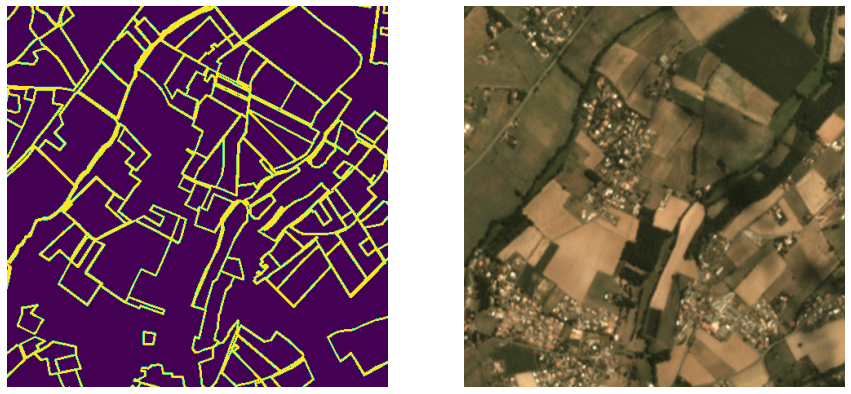

(467, 467)


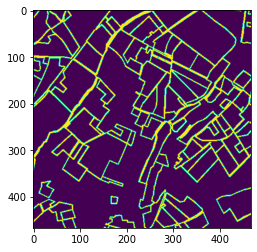

In [107]:
x = dataset[7]